In [1]:
from __future__ import print_function
#!pip install torch
#!pip install torchvision
import torch
from torchvision import datasets, transforms
import sys
import timeit
# !pip install factor_analyzer
from factor_analyzer import Rotator # May need to be installed; see https://pypi.org/project/factor-analyzer/
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from pylab import *
import pandas as pd

from utils import *
from helper_layers import *
from base_class import *
from mirt_vae import *
from read_data import *

# Re-import some packages to reload functions without needing to restart the kernel. jupyter notebook doesn't update the files in the same kernel
import sys, importlib
importlib.reload(sys.modules["utils"])
importlib.reload(sys.modules["helper_layers"])
importlib.reload(sys.modules["base_class"])
importlib.reload(sys.modules["mirt_vae"])
importlib.reload(sys.modules["read_data"])

from utils import *
from helper_layers import *
from base_class import *
from mirt_vae import *
from read_data import *

# Suppress scientific notation.
np.set_printoptions(suppress = True)

# Print full arrays.
np.set_printoptions(threshold = sys.maxsize)

# If CUDA is available, use it.
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
kwargs = {"num_workers" : 1, "pin_memory" : True} if cuda else {}

# Set log interval.
ipip_log_interval = 200

In [2]:
# To onehot-encode a datafile
ipip_filename = "ipip_ffm_recoded_int.csv"
ipip_csv = pd.read_csv(filepath_or_buffer = ipip_filename,
                       header = None)
enc = OneHotEncoder(categories = np.tile(np.array([[1,2,3,4,5]]), (ipip_csv.shape[1], 1)))
ipip_csv = enc.fit_transform(ipip_csv).toarray()
ipip_csv[0]

/Users/sharahe/opt/anaconda3/envs/pytorch_m1/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories != "auto":
/Users/sharahe/opt/anaconda3/envs/pytorch_m1/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:93: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories == "auto":


array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0.

In [3]:
## Start here to read in an integer-encoded datafile
ipip_filename = "ipip_ffm_recoded_int.csv"
csv_data = pd.read_csv(ipip_filename, sep = ",", header = None)
# Shift all data values from 1-5 scale to 0-4 scale
csv_data = csv_data.subtract(1)
csv_data.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,3.0,3.0,4.0,...,4.0,4.0,3.0,4.0,3.0,4.0,4.0,2.0,3.0,4.0
1,2.0,0.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,...,0.0,3.0,3.0,3.0,2.0,4.0,3.0,1.0,4.0,2.0
2,1.0,2.0,3.0,1.0,2.0,3.0,0.0,2.0,1.0,0.0,...,4.0,4.0,1.0,4.0,3.0,3.0,4.0,2.0,3.0,3.0
3,1.0,3.0,1.0,2.0,3.0,3.0,1.0,1.0,0.0,1.0,...,3.0,3.0,4.0,3.0,2.0,4.0,3.0,3.0,2.0,2.0
4,2.0,2.0,3.0,3.0,3.0,3.0,1.0,2.0,2.0,1.0,...,4.0,4.0,4.0,4.0,2.0,4.0,4.0,3.0,4.0,1.0


Model fitted for P = 1 , run time = 33.37 seconds
Computing approx. LL
Approx. LL computed in 8.14 seconds
Model fitted for P = 2 , run time = 49.65 seconds
Computing approx. LL
Approx. LL computed in 9.01 seconds


Latent dimension = 1 Approx. LL = 3506830.7
Latent dimension = 2 Approx. LL = 3384600.17


/Users/sharahe/Documents/GitHub/DeepIRTools/mirt_vae.py:496: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


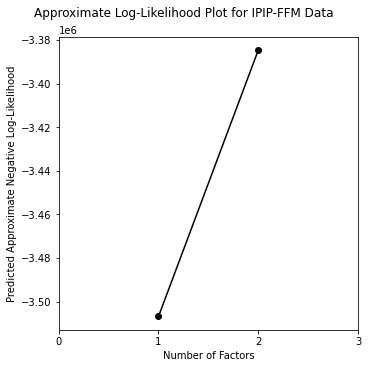

In [4]:
# Extract log likelihood
log_likelihoods, mirtvae_obj = screeplot(latent_dims = [1, 2],
                            csv_data = csv_data,
                            categories = np.tile(np.array([[1,2,3,4,5]]), (csv_data.shape[1], 1)),
                            n_cats = [5] * csv_data.shape[1],
                            device = device,
                            which_split = "full",
                            test_size = .1,
                            iw_samples_bic = 100,
                            title = "Approximate Log-Likelihood Plot for IPIP-FFM Data")


In [5]:
# Set random seeds.
seed = 1

# sets the seed for generating random numbers
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize model.
print("\rStarting fitting", end="")
sys.stdout.flush()

# starting the timer to count how much time is taken to run code
start = timeit.default_timer()
ipip_vae = MIRTVAEClass(input_dim = csv_data.shape[1], # number of columns in binarized data matrix
                        inference_model_dims = [int(np.ceil(csv_data.shape[1]/2))], # list of neural network hidden layer sizes
                        latent_dim = 5, # refers to the output num of dimensions after encoding
                        n_cats = [5] * 50, # list of number of categories for each item (because it's a range 1-5)
                        learning_rate = 5e-3, # rate at which the model learns 
                        device = device,
                        log_interval = ipip_log_interval,
                        steps_anneal = 1000)

"""
Fit model.
Note: iw_samples can be increased to improve the approximation to the MMLE.
As described in the paper, iw_samples = 5 seems to perform well in practice.
"""


# run training on the full dataloader and test loader
categories = np.tile(np.array([[1,2,3,4,5]]), (csv_data.shape[1], 1))
ipip_vae.run_training(csv_data, categories, iw_samples = 5)

# stopping timer
stop = timeit.default_timer()
run_time = stop - start
print("\rFitting completed in", round(run_time, 2), "seconds", end ="")
sys.stdout.flush()

# Extract estimated loadings and intercepts.
loadings = ipip_vae.get_unrotated_loadings

intercepts = ipip_vae.get_intercepts


"""
Rotate loadings and extract factor correlations.
Note: In the paper I used geomin rotation, whereas here I use oblimin.
"""

rot_loadings, cor_mat, rot_rotation = ipip_vae.get_rotated_loadings(loadings = loadings, method = "oblimin", loadings_only = False)


"""
Compute approximate log-likelihood.
Note: This computation can be sped up or slowed down by decreasing or increasing
iw_samples, respectively. In the paper, I set iw_samples = 5000. 
"""


ll = ipip_vae.bic(csv_data,
                  iw_samples = 100)[1]

Rotated loadings computed in 0.02 seconds
Computing approx. LL
Approx. LL computed in 95.92 seconds


In [6]:
print(ipip_vae.get_time_records)

{'Fitted Model': 66.8, 'Log-Likelihood': 95.92, 'Rotated Loadings': 0.02}


In [8]:
print(cor_mat)

[[ 1.         -0.01359453 -0.07359794 -0.20785406  0.25223645]
 [-0.01359453  1.         -0.10665064 -0.20056195  0.0763393 ]
 [-0.07359794 -0.10665064  1.          0.14528547 -0.00930019]
 [-0.20785406 -0.20056195  0.14528547  1.         -0.05259341]
 [ 0.25223645  0.0763393  -0.00930019 -0.05259341  1.        ]]


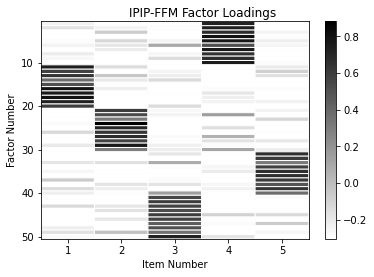

In [9]:
loadings_heatmap(rot_loadings, loadings, x_label = "Item Number", y_label = "Factor Number", title = "IPIP-FFM Factor Loadings")